## Setup and Dataset
- create a simple 2-D datset (two clusters)
- split into train/val/test
- standardize it
- visualize it

Raw shapes -> X: (1200, 2)  y: (1200, 1)
Class balance -> #0: 600  #1: 600
Splits -> train: (840, 2) val: (180, 2) test: (180, 2)
Standardization -> mean: [-0.01127425  0.01960937]  std: [1.2668191 1.3001944]


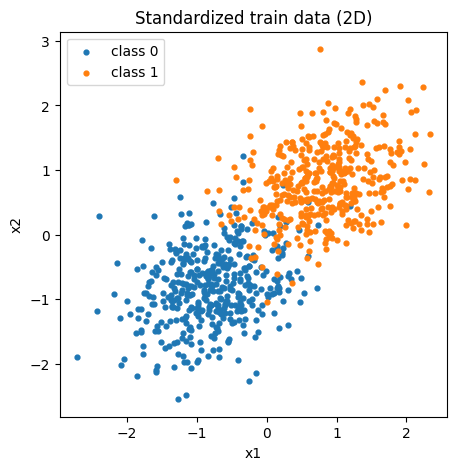

In [6]:
# imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# class 0 centered near (-1, -1), class 1 centered near (1, 1)
n0, n1 = 600, 600   # number of samples
# covariance matrix for spread and orientation
cov = [[0.6, 0.2],
       [0.2, 0.6]]

# n0 samples for class 0, shape (n0, 2)
X0 = np.random.multivariate_normal(mean=[-1.0, -1.0], cov=cov, size=n0)
# n1 sample for class 1, shape (n1, 2)
X1 = np.random.multivariate_normal(mean=[ 1.0,  1.0], cov=cov, size=n1)
# label array for class 0, shape (600, 1)
y0 = np.zeros((n0, 1), dtype=np.float32)
# label array for class 1, shape (600, 1)
y1 = np.ones((n1, 1), dtype=np.float32)

# combine the data for both classes into a single dataset
X = np.vstack([X0, X1]).astype(np.float32)  # (1200, 2)
y = np.vstack([y0, y1])                     # (1200, 1)

# shuffle once
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

print("Raw shapes -> X:", X.shape, " y:", y.shape)
print("Class balance -> #0:", int((y==0).sum()), " #1:", int((y==1).sum()))

# train/val/test split: 70/15/15
N = len(X)
n_train = int(0.7 * N)
n_val = int(0.15 * N)
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

print("Splits ->",
      "train:", X_train.shape, 
      "val:",   X_val.shape, 
      "test:",  X_test.shape)

# standardize using training stats only
mean = X_train.mean(axis=0, keepdims=True)
std  = X_train.std(axis=0, keepdims=True) + 1e-8
X_train_std = (X_train - mean) / std
X_val_std = (X_val - mean) / std
X_test_std = (X_test - mean) / std

print("Standardization -> mean:", mean.ravel(), " std:", std.ravel())

# visualization of training set
mask0 = (y_train.ravel() == 0)
mask1 = ~mask0

plt.figure(figsize=(5, 5))
plt.scatter(X_train_std[mask0, 0], X_train_std[mask0, 1], s=12, label="class 0")
plt.scatter(X_train_std[mask1, 0], X_train_std[mask1, 1], s=12, label="class 1")
plt.title("Standardized train data (2D)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

## Build the Neural Network
2 -> 4 -> 1 architecture
- input layer: 2 features (2d points)
- hidden layer: 4 neurons, ReLU activation
- output layer: 1 neuron, sigmoid activation (probability for class 1)

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

# simple sequential model
model = keras.Sequential([
    layers.Input(shape=(2,), name="input_layer"),               # 2 features
    layers.Dense(4, activation='relu', name='hidden_layer'),    # hidden layer with 4 neurons
    layers.Dense(1, activation='sigmoid', name="output_layer")  # output layer for binary classification
])

# print model architecture summary
print("\nModel summary:")
model.summary()


Model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer (Dense)            │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

## Compile, build datasets, and train
- choose loss/optimizer/metrics
- create efficient tf.data pipelines
- train with validation

In [9]:
batch_size = 64
shuffle_buffer = len(X_train_std)

# tf.data input pipelines (shuffled train, plain val/test)
train_ds = tf.data.Dataset.from_tensor_slices((X_train_std, y_train)) \
                          .shuffle(buffer_size=shuffle_buffer, seed=seed) \
                          .batch(batch_size) \
                          .prefetch(tf.data.AUTOTUNE)

val_ds   = tf.data.Dataset.from_tensor_slices((X_val_std, y_val)) \
                          .batch(batch_size) \
                          .prefetch(tf.data.AUTOTUNE)

test_ds  = tf.data.Dataset.from_tensor_slices((X_test_std, y_test)) \
                          .batch(batch_size) \
                          .prefetch(tf.data.AUTOTUNE)

# compile the model
# - binary cross-entropy for binary classification
# - adam for optimizer
# - track accuracy + AUC for extra insight
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name="acc"),
             keras.metrics.AUC(name="auc")]
)

# callbacks: early stopping to avoid overfitting
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# train
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=1
)

# validation set evaluation print
val_metrics = model.evaluate(val_ds, verbose=0)
print(f"\n[eval] Validation -> loss: {val_metrics[0]:.4f} | acc: {val_metrics[1]:.4f} | auc: {val_metrics[2]:.4f}")

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9524 - auc: 0.9682 - loss: 0.4884 - val_acc: 0.9389 - val_auc: 0.9417 - val_loss: 0.4833
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - acc: 0.9512 - auc: 0.9740 - loss: 0.4634 - val_acc: 0.9389 - val_auc: 0.9641 - val_loss: 0.4590
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - acc: 0.9560 - auc: 0.9814 - loss: 0.4402 - val_acc: 0.9389 - val_auc: 0.9784 - val_loss: 0.4365
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - acc: 0.9548 - auc: 0.9858 - loss: 0.4194 - val_acc: 0.9333 - val_auc: 0.9862 - val_loss: 0.4160
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - acc: 0.9536 - auc: 0.9871 - loss: 0.4002 - val_acc: 0.9333 - val_auc: 0.9885 - val_loss: 0.3974
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - acc: 0.9512 - auc: 0.9884 - loss: 0.3829 - val_acc: 0.9333 - val_auc: 0.9906 - val_loss: 0.3808
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - acc: 0.9512 - auc: 0.9885 - loss: 0.3675 